In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 50
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4) + cliff(x5, x6)
        ).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=1000000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINetRegressor(interact_num=20,
                hidden_layer_sizes_main_effect=[40] * 5, hidden_layer_sizes_interaction=[40] * 5,
                batch_size=1000, activation_func=torch.nn.ReLU(),
                max_epoch_main_effect=1000, max_epoch_interaction=1000, max_epoch_tuning=100,
                learning_rates=[0.001, 0.001, 0.001], early_stop_thres=[0, 0, 0],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                reg_mono=1, mono_increasing_list=[0], mono_decreasing_list=[1],
                warm_start=True, verbose=True, val_ratio=0.2, device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
                random_state=random_state)
model.init_fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:   2, train loss: 0.00763: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]                                               


Main Effect Training Stop at Epoch: 2, train loss: 0.00763, val loss: 0.00773
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:   9, train loss: 0.00208: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]                                               


Interaction Training Stop at Epoch: 9, train loss: 0.00208, val loss: 0.00203
####################Stage 3: Fine Tuning####################


Epoch: 11, train loss: 0.00184: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]                                                


Fine Tuning Stop at Epoch: 11, train loss: 0.00184, val loss: 0.00180


In [4]:
from pygam.terms import TermList
from pygam import LinearGAM, LogisticGAM, f, s, te
from sklearn.neural_network import MLPRegressor, MLPClassifier


termlist = TermList()
for idx, (key, item) in enumerate(model.meta_info.items()):
    if item["type"] == "continuous":
        if idx in model.mono_increasing_list:
            constraints = "monotonic_inc"
        elif idx in model.mono_decreasing_list:
            constraints = "monotonic_dec"
        elif idx in model.convex_list:
            constraints = "convex"
        elif idx in model.concave_list:
            constraints = "concave"
        else:
            constraints = None
        termlist += s(idx, spline_order=1, lam=0.6, constraints=constraints)
    elif item["type"] == "categorical":
        termlist += f(idx)
    else:
        continue

gam = LinearGAM(termlist)
allx = torch.vstack([model.tr_x, model.val_x])
ally = torch.vstack([model.tr_y, model.val_y])

suffleidx = np.arange(allx.shape[0])
np.random.shuffle(suffleidx)
subx = allx[suffleidx][:5000]
suby = ally[suffleidx][:5000]
gam.fit(subx.detach().cpu().numpy(), suby.detach().cpu().numpy())

def margial_effect(i):
    return lambda x: gam.partial_dependence(i, x)

intercept = gam.coef_[-1]
surrogate_estimator = [margial_effect(i) for i in range(model.n_features)]

In [7]:
mlp_list = []
for idx in range(model.n_features):
    n_simu_sample = 1000
    simu_xx = np.zeros((n_simu_sample, model.n_features))
    simu_xx[:, idx] = np.random.uniform(model.min_value[idx], model.max_value[idx], n_simu_sample)
    simu_yy = surrogate_estimator[idx](simu_xx)
    mlp = MLPRegressor(hidden_layer_sizes=model.hidden_layer_sizes_main_effect,
                     max_iter=1000, early_stopping=True, n_iter_no_change=5, validation_fraction=0.2,
                     batch_size=200, solver='adam', activation="relu",
                     learning_rate_init=0.01, random_state=model.random_state)
    mlp.fit(simu_xx[:, [idx]], simu_yy)
    mlp_list.append(mlp)

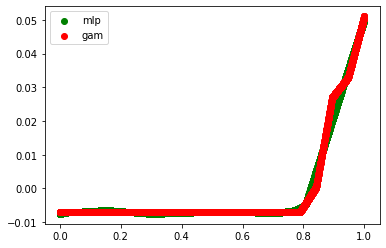

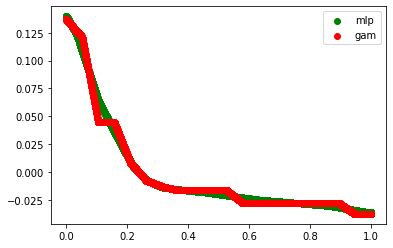

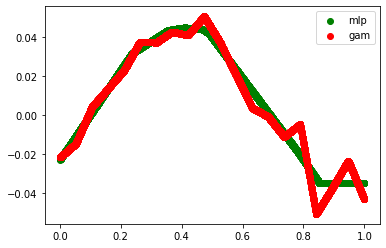

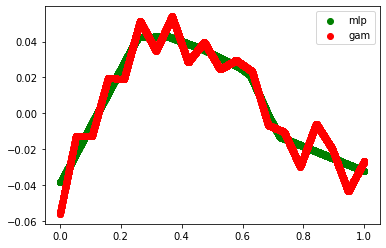

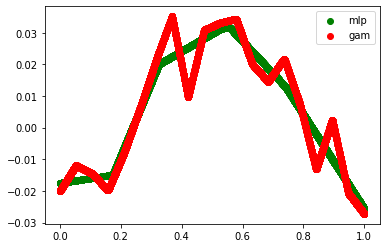

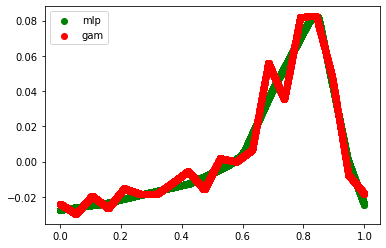

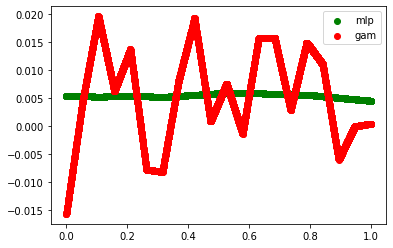

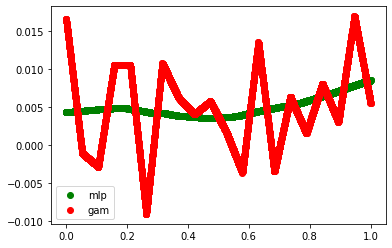

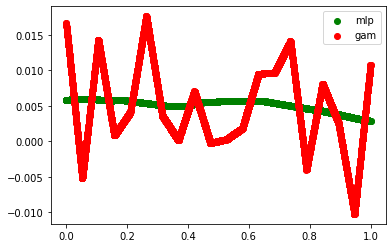

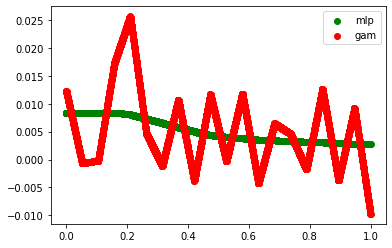

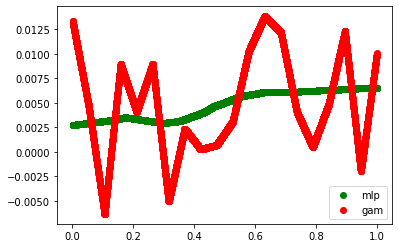

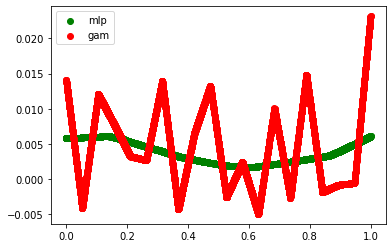

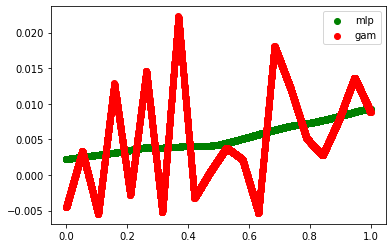

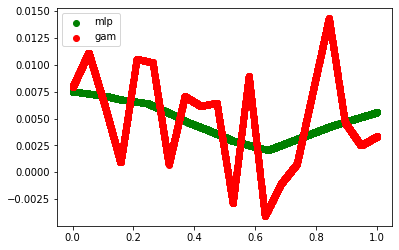

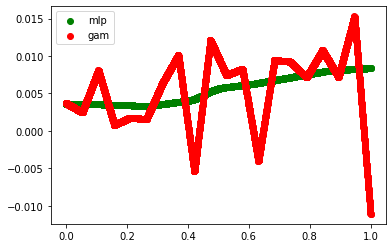

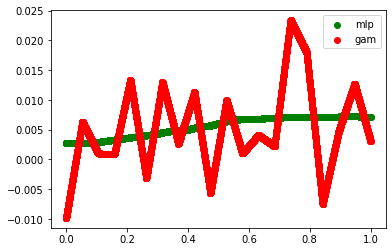

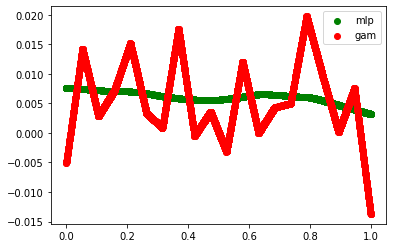

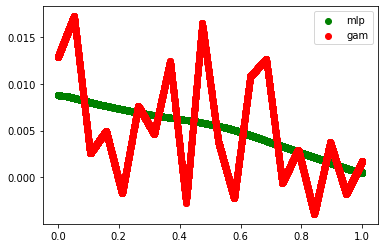

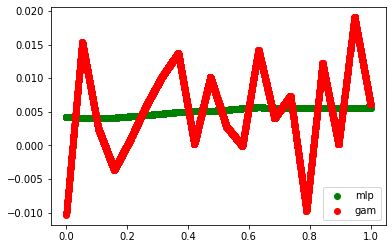

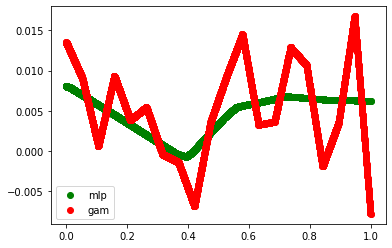

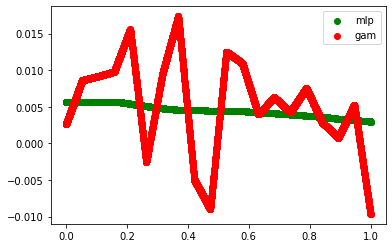

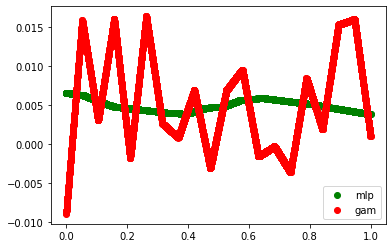

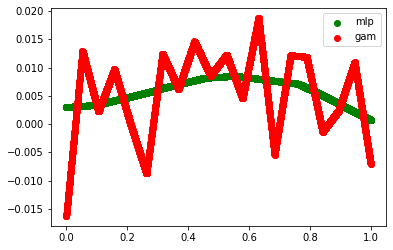

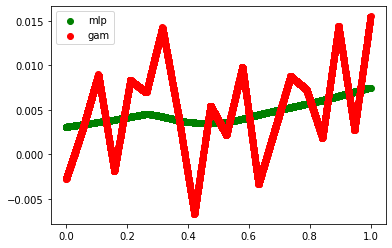

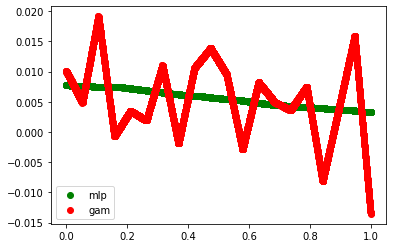

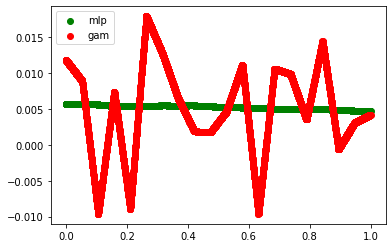

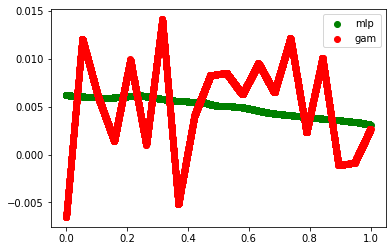

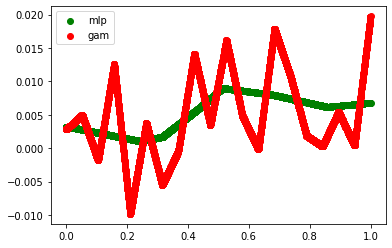

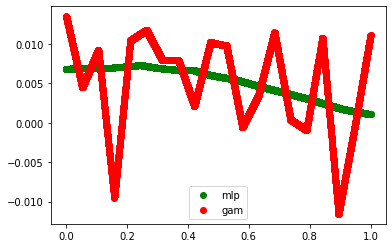

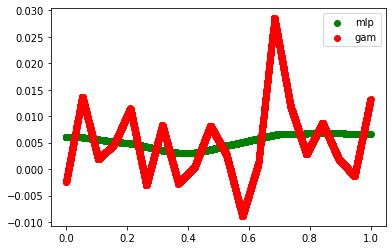

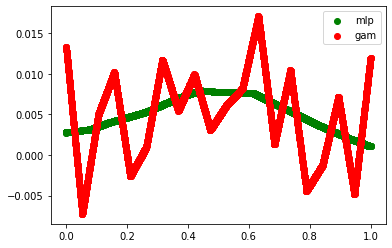

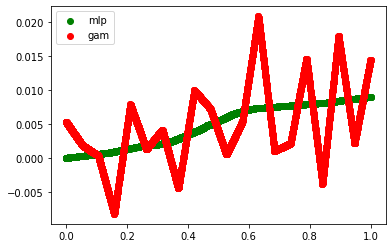

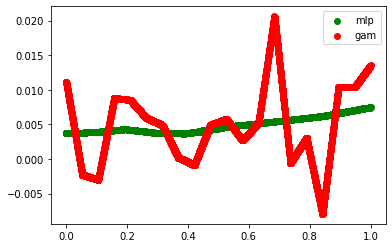

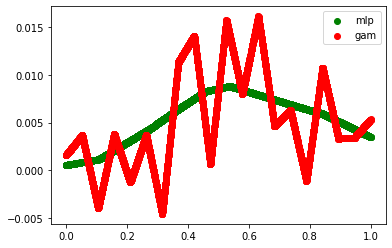

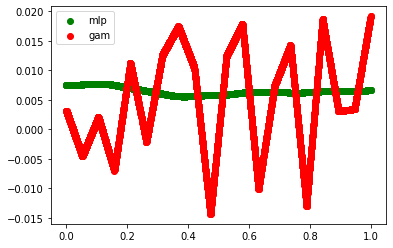

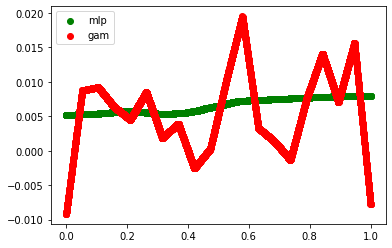

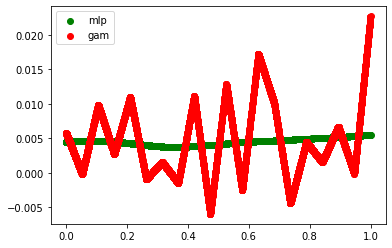

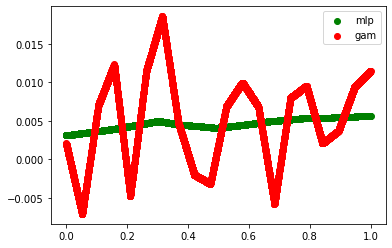

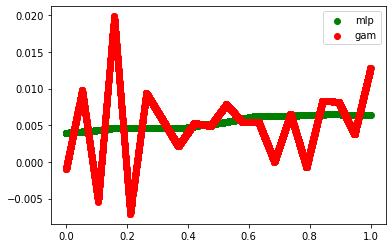

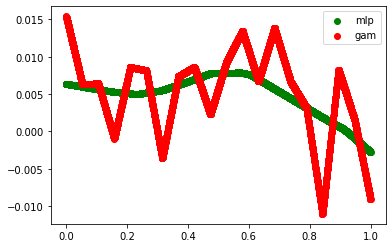

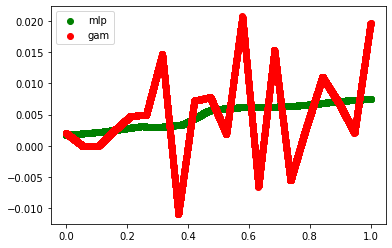

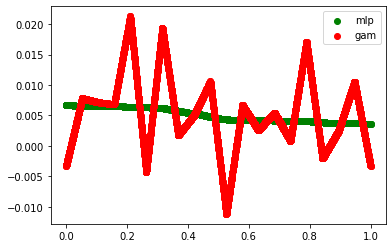

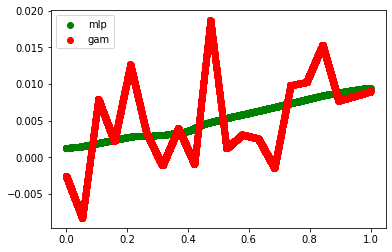

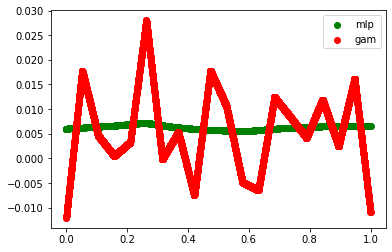

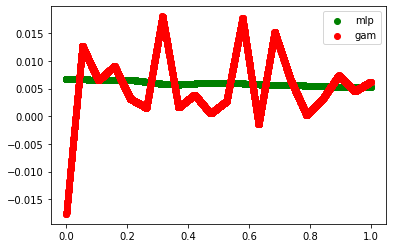

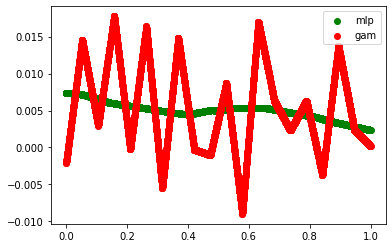

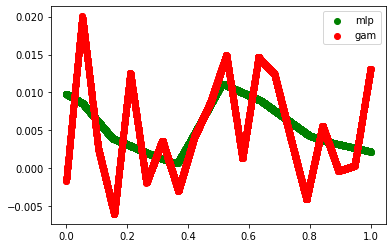

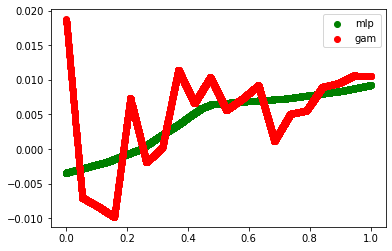

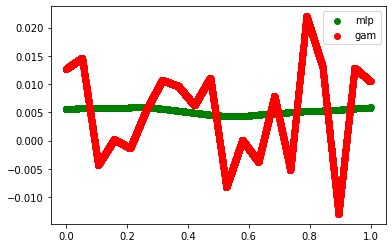

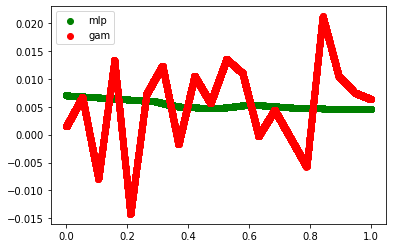

In [8]:
from matplotlib import pylab as plt

mlp_pred_all = 0
gam_pred_all = 0
n_samples = 10000
for idx in range(model.n_features):
    mlp_pred = mlp_list[idx].predict(train_x[:n_samples, [idx]])
    gam_pred = surrogate_estimator[idx](train_x[:n_samples])
    mlp_pred_all += mlp_pred
    gam_pred_all += gam_pred
    plt.scatter(train_x[:n_samples,idx], mlp_pred, color="green", label="mlp")
    plt.scatter(train_x[:n_samples,idx], gam_pred, color="red", label="gam")
    plt.legend()
    plt.show()

In [29]:
import time
from tqdm import tqdm

last_improvement = 0
best_validation = np.inf
train_size = model.tr_x.shape[0]
opt = torch.optim.Adam(list(model.net.main_effect_blocks.parameters()) +
                   [model.net.main_effect_weights, model.net.output_bias], lr=0.0001)

for epoch in range(model.max_epoch_main_effect):
    model.net.train()
    accumulated_size = 0
    accumulated_loss = 0.0
    pbar = tqdm(model.training_generator, total=model.max_iteration_per_epoch, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    for batch_no, batch_data in enumerate(pbar):
        if batch_no >= model.max_iteration_per_epoch:
            break
        opt.zero_grad(set_to_none=True)
        batch_xx = batch_data[0].to(model.device)
        batch_yy = batch_data[1].to(model.device).ravel()
        batch_sw = batch_data[2].to(model.device).ravel()
        pred = model.net(batch_xx, sample_weight=batch_sw,
                   main_effect=True, interaction=False,
                   clarity=False,
                   monotonicity=model.monotonicity and model.reg_mono > 0,
                   convexity=model.convexity and model.reg_conv > 0).ravel()
        mono_loss_reg = 0.1 * model.net.mono_loss
        mono_loss_reg.backward(retain_graph=True)
        loss = torch.mean(model.loss_fn(pred, batch_yy) * batch_sw)
        loss.backward()
        opt.step()
        accumulated_size += batch_xx.shape[0]
        accumulated_loss += (loss * batch_xx.shape[0]).cpu().detach().numpy()
        if model.verbose:
            pbar.set_description(("Epoch: %" + str(int(np.ceil(np.log10(model.max_epoch_main_effect))))
                          + "d, train loss: %0.5f") % (epoch + 1, accumulated_loss / accumulated_size))
#         time.sleep(1)
    break

Epoch:   1, train loss: 0.00741: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]                                               
